In [5]:
import pandas as pd
import numpy as np
import pathlib as pl
import os
import requests

# Get ASEC data from CPS API

## Variables to Retrieve

In [68]:
ASEC_VARIABLES = [
    'PEMLR', # labor force status
    'A_AGE',
    'A_SEX',
    'A_HGA',
    'PRDTRACE',
    'PEHSPNON',
    'PRDISFLG',
    'PRCITSHP',
    'MARSUPWT',
    'A_LFSR',
    'HRCHECK',
    'A_CLSWKR',
    'CLWK',
    'A_DTOCC', # last year major occ
    'WEMIND', # last year major ind
    'A_MJIND',
    'LJCW',
    'HTOTVAL',
    'A_MARITL',
    # 'HCOV',  # health insurance coverage last year
    'FPERSONS',  # number of persons in family
    'FRELU18',  # number of persons in family under 18
]

## Get single year of ASEC data

In [24]:
# this function will retrieve an entire year of ASEC data
def get_asec_year_df(api_key, asec_variables, year):
    base_url = f'https://api.census.gov/data/{year}/cps/asec/mar'
    get_vars = ','.join(asec_variables)
    url = f'{base_url}?get={get_vars}&key={api_key}'
    response = requests.get(url)
    
    data = response.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    
    df = df.rename(columns={x: x.lower() for x in df.columns})
    df.loc[:, 'year'] = year
    
    for var in df.columns:
        if var == 'marsupwt':
            df[var] = df[var].astype(np.float64)
        else:
            df[var] = df[var].astype(np.int64)
            
    return df

# I've saved my API key in a local file
with open('c:/users/calvi/coding/census_api_key.txt', 'r') as f:
    api_key = f.readline().strip()

asec_2024 = get_asec_year_df(api_key, ASEC_VARIABLES, 2024)
asec_2024.head()

,a_age,a_sex,a_hga,prdtrace,pehspnon,prdisflg,prcitshp,marsupwt,a_lfsr,hrcheck,...,a_dtocc,wemind,a_mjind,ljcw,pearnval,htotval,a_maritl,fpersons,frelu18,year
0,68,2,39,1,2,2,1,1061.89,1,2,...,17,4,10,1,55000,262579,1,2,0,2024
1,68,1,43,1,2,2,1,1061.89,1,2,...,16,5,5,1,24000,262579,1,2,0,2024
2,58,2,44,1,2,1,1,4788.10,1,2,...,8,10,10,4,95000,96802,5,1,0,2024
3,71,2,43,1,2,2,1,5180.75,7,0,...,0,15,0,0,0,104000,1,2,0,2024
4,70,1,46,1,2,2,1,5180.75,7,2,...,0,10,0,1,55000,104000,1,2,0,2024


In [69]:
asec_df = pd.DataFrame()
base_year = 2024
start_year = base_year - 9
for year in range(start_year, base_year + 1):
    print(f'Processing year {year}')
    df_year = get_asec_year_df(api_key, ASEC_VARIABLES, year)
    asec_df = pd.concat([
        asec_df,
        df_year
    ])

asec_df.head()

Processing year 2015
Processing year 2016
Processing year 2017
Processing year 2018
Processing year 2019
Processing year 2020
Processing year 2021
Processing year 2022
Processing year 2023
Processing year 2024


,pemlr,a_age,a_sex,a_hga,prdtrace,pehspnon,prdisflg,prcitshp,marsupwt,a_lfsr,...,a_dtocc,wemind,a_mjind,ljcw,pearnval,htotval,a_maritl,fpersons,frelu18,year
0,1,48,1,41,1,2,2,1,690.05,1,...,22,2,6,1,40000,63930,1,2,0,2015
1,6,45,2,40,2,2,2,1,690.05,7,...,0,11,0,1,6000,63930,1,2,0,2015
2,1,23,2,39,1,2,2,1,583.80,1,...,16,5,5,1,16000,63930,3,2,1,2015
3,0,2,2,0,1,2,-1,1,468.04,0,...,0,0,0,0,0,63930,7,2,1,2015
4,5,80,2,39,1,2,1,1,735.83,7,...,0,15,0,0,0,11831,4,1,0,2015


## Save raw ASEC data to parquet

In [70]:
parquets_dir = pl.Path('model.ipynb').resolve().parent/'parquets'
if not os.path.exists(str(parquets_dir)):
    os.makedirs(str(parquets_dir))
parquet_file_path = parquets_dir/f'asec_{start_year}to{base_year}.parquet'

asec_df.to_parquet(parquet_file_path)

# Transform ASEC data to prepare for modeling

In [71]:
parquets_dir = pl.Path('model.ipynb').resolve().parent/'parquets'
parquet_file_path = parquets_dir/f'asec_{start_year}to{base_year}.parquet'
asec = pd.read_parquet(parquet_file_path)

## Remove rows

Starting with 1,695,000 rows

In [72]:
print(len(asec))

1695242


In [73]:
# ! filter with WKSWORK to exclude people who barely worked?

# only include people who worked in paying jobs last year
asec = asec[asec.ljcw.isin([1,2,3,4,5,6])].reset_index(drop=True)

len(asec)

847026

## Create modeling variables

### Education

In [74]:
def get_edu_var(df):
    df = df.copy()
    bins = [30, 39, 40, 41, 43, 44, 45, np.inf]
    names = ['LTHS', 'HS', 'SCND', 'AD', 'BA', 'MA', 'DOC']
    df['edu'] = pd.cut(df['a_hga'], bins, labels=names, right=False)
    
    return df

asec = get_edu_var(asec)
asec.edu.value_counts()

edu
HS      220119
BA      194849
SCND    145246
AD       90375
MA       85058
LTHS     79707
DOC      31672
Name: count, dtype: int64

### Race

In [75]:
def get_race_var(df):
    df = df.copy()
    df['race'] = 'other'
    df.loc[df.prdtrace == 1, 'race'] = 'white'
    df.loc[df.prdtrace == 2, 'race'] = 'black'
    df.loc[df.prdtrace == 4, 'race'] = 'asian'
    
    return df

asec = get_race_var(asec)
asec.race.value_counts()

race
white    661835
black     94406
asian     56524
other     34261
Name: count, dtype: int64

### Hispanic

In [76]:
def get_hispanic_var(df):
    df = df.copy()
    df['hisp'] = 0
    df.loc[df.pehspnon==1, 'hisp'] = 1
    
    return df

asec = get_hispanic_var(asec)
asec.hisp.value_counts()

hisp
0    685960
1    161066
Name: count, dtype: int64

### Sex

In [77]:
def get_male_var(df):
    df = df.copy()
    df['male'] = 0
    df.loc[df.a_sex==1, 'male'] = 1
    
    return df

asec = get_male_var(asec)
asec.male.value_counts()

male
1    441229
0    405797
Name: count, dtype: int64

### Citizenship

In [78]:
def get_citizenship_var(df):
    df = df.copy()
    bins = [1, 4, 5, np.inf]
    names = ['native', 'naturalized', 'noncitizen']
    df.loc[:, 'citshp'] = pd.cut(df['prcitshp'],
                                 bins=bins, labels=names, right=False, include_lowest=True)
    
    return df

asec = get_citizenship_var(asec)
asec.citshp.value_counts()

citshp
native         700363
noncitizen      76079
naturalized     70584
Name: count, dtype: int64

### Class of worker

In [79]:
def get_cow_var(df):
    df = df.copy()
    bins = [1, 2, 5, 6, np.inf]
    names = ['ws', 'gov', 'seinc', 'seuninc']
    df.loc[:, 'cow'] = pd.cut(df['ljcw'],
                                 bins=bins, labels=names, 
                                 right=False, include_lowest=True)
    
    return df

asec = get_cow_var(asec)
asec.cow.value_counts()

cow
ws         639444
gov        128180
seuninc     50159
seinc       29243
Name: count, dtype: int64

### Full-time/part-time

In [80]:
def get_pt_var(df):
    df = df.copy()
    df['pt'] = 0
    df.loc[df.hrcheck == 1, 'pt'] = 1
    
    return df

asec = get_pt_var(asec)
asec.pt.value_counts()

pt
0    682731
1    164295
Name: count, dtype: int64

### Disability

In [81]:
def get_disability_var(df):
    df = df.copy()
    df['disability'] = 0
    df.loc[df.prdisflg == 1, 'disability'] = 1
    
    return df

asec = get_disability_var(asec)
asec.disability.value_counts()

disability
0    809534
1     37492
Name: count, dtype: int64

### Marital Status

In [84]:
def get_married_var(df):
    df = df.copy()
    df['married'] = 0
    df.loc[df.a_maritl.isin([1,2,3]), 'married'] = 1
    
    return df

asec = get_married_var(asec)
asec.married.value_counts()

married
1    478408
0    368618
Name: count, dtype: int64

### Children

In [86]:
def get_children_var(df):
    df = df.copy()
    df['children'] = 0
    df.loc[df.frelu18 > 0, 'children'] = 1
    
    return df

asec = get_children_var(asec)
asec.children.value_counts()

children
0    464544
1    382482
Name: count, dtype: int64

### Income

Use log income because income distribution is skewed right

In [87]:
# ! need to adjust for inflation
def get_log_income_var(df):
    df = df.copy()
    # initially set to 0
    df['log_income'] = 0.0
    # only assign log value to positive values - we will treat negative and 0 income as all having 0 here
    df.loc[df.htotval > 0, 'log_income'] = np.log(df[df.htotval > 0].htotval)
    
    return df

asec = get_log_income_var(asec)
asec.log_income.describe()

count    847026.000000
mean         11.402650
std           0.858329
min           0.000000
25%          10.933107
50%          11.461843
75%          11.931682
max          15.009578
Name: log_income, dtype: float64

### LF leaver label

In [89]:
def get_leaver_var(df):
    df = df.copy()
    df['leaver'] = 0
    df.loc[~df.pemlr.isin([1,2]), 'leaver'] = 1
    
    return df

asec = get_leaver_var(asec)
asec.leaver.value_counts()

leaver
0    762546
1     84480
Name: count, dtype: int64

In [91]:
asec.wemind.value_counts()

wemind
10    194653
5     107915
9      98135
11     81823
4      79697
3      60256
8      53674
6      45739
13     43683
12     40626
1      15785
7      14841
2       5687
14      4512
Name: count, dtype: int64

## Rename some variables

In [93]:
asec = asec.rename(columns={
    'a_dtocc': 'occ',
    'wemind': 'ind',
    'a_age': 'age'
})

asec.columns

Index(['pemlr', 'age', 'a_sex', 'a_hga', 'prdtrace', 'pehspnon', 'prdisflg',
       'prcitshp', 'marsupwt', 'a_lfsr', 'hrcheck', 'a_clswkr', 'clwk',
       'peio1cow', 'wemocg', 'occ', 'ind', 'a_mjind', 'ljcw', 'pearnval',
       'htotval', 'a_maritl', 'fpersons', 'frelu18', 'year', 'edu', 'race',
       'hisp', 'male', 'citshp', 'cow', 'pt', 'disability', 'married',
       'children', 'log_income', 'leaver'],
      dtype='object')

## Save modeling data

In [101]:
model_data = asec[[
    'marsupwt', 'leaver',  # weight and label
    'age', 'log_income',  # continuous variables
    'pt', 'hisp', 'male', 'disability', 'married', 'children',  # binary variables
    'cow', 'race', 'citshp', 'edu', 'occ', 'ind' # categorical variables
]].copy()

model_data.head()

,marsupwt,leaver,age,log_income,pt,hisp,male,disability,married,children,cow,race,citshp,edu,occ,ind
0,690.05,0,48,11.065544,0,0,1,0,1,0,ws,white,native,AD,22,2
1,690.05,1,45,11.065544,1,0,0,0,1,0,ws,black,native,SCND,0,11
2,583.80,0,23,11.065544,0,0,0,0,1,1,ws,white,native,HS,16,5
3,513.98,0,64,10.196344,0,0,0,0,0,1,gov,white,native,SCND,8,10
4,785.82,0,46,11.611141,0,0,0,0,1,0,gov,white,native,HS,2,13


In [102]:
cat_vars = ['cow', 'race', 'citshp', 'edu', 'occ', 'ind']

for var in cat_vars:
    model_data[var] = model_data[var].astype('category')

# one-hot encode categorical variables
model_data = pd.get_dummies(model_data, drop_first=True,
                            columns=cat_vars, dtype=np.int8)

model_data.head()

,marsupwt,leaver,age,log_income,pt,hisp,male,disability,married,children,...,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14
0,690.05,0,48,11.065544,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,690.05,1,45,11.065544,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,583.80,0,23,11.065544,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
3,513.98,0,64,10.196344,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,785.82,0,46,11.611141,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


Save to a parquet file

In [103]:
model_data_parquet_path = parquets_dir/f'leavers_model_data{base_year}.parquet'
model_data.to_parquet(model_data_parquet_path)

print(f'Saved model data as a parquet file: {str(model_data_parquet_path)}')

Saved model data as a parquet file: C:\Users\calvi\github\asec-separations-model\parquets\leavers_model_data2024.parquet


# Do some modeling

In [104]:
model_data = pd.read_parquet(model_data_parquet_path)
model_data.head()

,marsupwt,leaver,age,log_income,pt,hisp,male,disability,married,children,...,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14
0,690.05,0,48,11.065544,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,690.05,1,45,11.065544,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,583.80,0,23,11.065544,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
3,513.98,0,64,10.196344,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,785.82,0,46,11.611141,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## Train-test split

In [106]:
sample = model_data.sample(500000, random_state=42).reset_index(drop=True)

sample.shape

(500000, 60)

In [109]:
from sklearn.preprocessing import StandardScaler

continuous_features = ['age', 'log_income']
scaler = StandardScaler()
sample[continuous_features] = scaler.fit_transform(sample[continuous_features])

sample.head()

,marsupwt,leaver,age,log_income,pt,hisp,male,disability,married,children,...,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14
0,2040.38,0,-0.023675,-0.632230,0,0,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,1613.71,0,-1.743965,-0.954986,1,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,3596.34,0,-0.918226,0.272089,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,3235.01,0,1.352557,0.061264,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1718.68,0,0.113948,-0.086082,0,0,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0


Get train-test split

In [120]:
from sklearn.model_selection import train_test_split

X = sample.drop(columns=['leaver', 'marsupwt'])
y = sample['leaver']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('training #:', len(X_train))
print('testing #:', len(X_test))

training #: 400000
testing #: 100000


## PCA

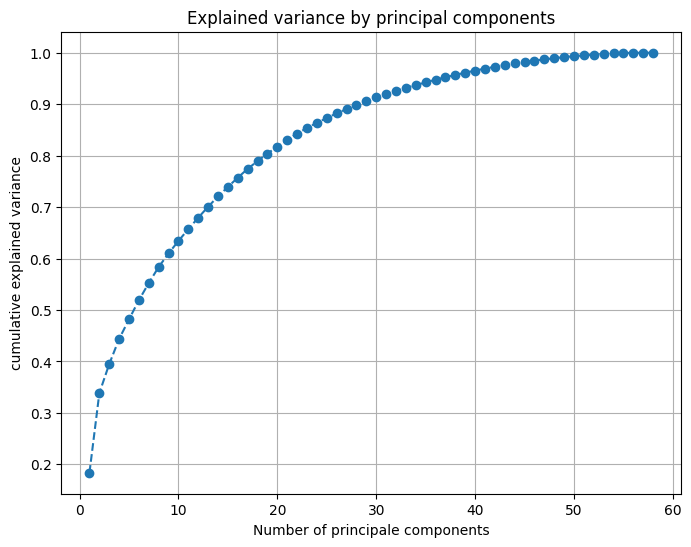

In [121]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



# Run PCA, reducing the data to 2 components
pca = PCA()
pca.fit(X_train)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1),
        explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of principale components")
plt.ylabel("cumulative explained variance")
plt.title("Explained variance by principal components")
plt.grid()
plt.show()


In [124]:
component_df = pd.DataFrame(pca.components_, columns=X.columns,
                             index=[f'PC{i+1}' for i in range(pca.n_components_)])
display(component_df)

,age,log_income,pt,hisp,male,disability,married,children,cow_gov,cow_seinc,...,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14
PC1,0.676228,0.668113,-0.073793,-0.066923,0.020494,0.002626,0.222156,-0.049571,0.037551,0.022273,...,-0.031339,0.003676,0.002908,0.020693,0.020389,0.033645,-0.061087,-0.005239,0.017376,-0.001735
PC2,0.694408,-0.692882,0.015190,0.013016,-0.008664,0.030706,0.011254,-0.139348,-0.000102,0.001827,...,0.000544,0.008945,-0.003669,-0.007917,-0.011604,-0.003010,-0.018092,0.013485,-0.001736,-0.002298
PC3,-0.003482,0.037085,-0.136426,0.126896,0.656572,-0.001308,0.081845,-0.002725,-0.202047,0.027110,...,0.082031,0.053704,0.004872,0.009046,0.059200,-0.491133,0.017669,0.010623,-0.022793,0.002446
PC4,-0.020543,-0.174889,-0.047647,0.091912,-0.012037,-0.023368,0.586828,0.697363,0.062994,0.005640,...,-0.068717,-0.011237,-0.004285,-0.007510,-0.012275,0.102610,-0.053998,0.000794,0.003840,0.006660
PC5,0.049153,0.089141,0.246948,0.279274,-0.333358,0.018399,-0.125646,-0.116853,-0.123433,-0.001598,...,0.100843,-0.034276,-0.006844,-0.007686,-0.044905,-0.003526,0.076013,0.022662,-0.062225,-0.008919
PC6,0.021327,0.125610,0.020726,-0.025401,-0.184044,-0.004041,0.062785,0.203932,0.016092,-0.017132,...,0.018212,0.028886,-0.013772,-0.042874,-0.101543,0.086391,0.024323,0.004411,-0.009202,-0.000940
PC7,-0.089250,-0.032189,-0.310419,0.126663,0.262698,-0.012879,-0.054611,-0.286034,0.348801,-0.029789,...,-0.280142,0.007520,-0.007334,-0.076596,-0.094613,0.412132,-0.117759,-0.038313,0.080250,0.009325
PC8,0.025335,0.021673,0.040232,0.030285,0.266971,0.012931,-0.024750,0.027542,0.172088,-0.008782,...,-0.067434,0.022324,-0.005592,-0.060321,-0.095196,0.128303,0.000583,-0.011416,0.052963,0.008015
PC9,0.032898,0.052831,-0.170770,0.719706,-0.181981,-0.031043,-0.050277,-0.008158,-0.142894,-0.003873,...,-0.234120,-0.007234,-0.001454,0.010250,0.162718,-0.050291,0.059225,0.017434,-0.046255,-0.008096
PC10,0.075167,0.039900,0.631754,-0.061971,0.250920,0.033736,-0.169807,0.154705,-0.075191,0.024996,...,-0.348155,-0.016982,-0.000201,-0.067339,0.093333,0.095925,0.324533,0.027715,-0.072024,-0.005486


In [125]:
explained_variance_ratio = pca.explained_variance_ratio_

# Rank the importance of variables
importance_rank = np.argsort(explained_variance_ratio)[::-1]

# Print the ranked variables
for i, var_index in enumerate(importance_rank):
    print(f"Rank {i+1}: Variable {X.columns[var_index]}")

Rank 1: Variable age
Rank 2: Variable log_income
Rank 3: Variable pt
Rank 4: Variable hisp
Rank 5: Variable male
Rank 6: Variable disability
Rank 7: Variable married
Rank 8: Variable children
Rank 9: Variable cow_gov
Rank 10: Variable cow_seinc
Rank 11: Variable cow_seuninc
Rank 12: Variable race_black
Rank 13: Variable race_other
Rank 14: Variable race_white
Rank 15: Variable citshp_naturalized
Rank 16: Variable citshp_noncitizen
Rank 17: Variable edu_HS
Rank 18: Variable edu_SCND
Rank 19: Variable edu_AD
Rank 20: Variable edu_BA
Rank 21: Variable edu_MA
Rank 22: Variable edu_DOC
Rank 23: Variable occ_1
Rank 24: Variable occ_2
Rank 25: Variable occ_3
Rank 26: Variable occ_4
Rank 27: Variable occ_5
Rank 28: Variable occ_6
Rank 29: Variable occ_7
Rank 30: Variable occ_8
Rank 31: Variable occ_9
Rank 32: Variable occ_10
Rank 33: Variable occ_11
Rank 34: Variable occ_12
Rank 35: Variable occ_13
Rank 36: Variable occ_14
Rank 37: Variable occ_15
Rank 38: Variable occ_16
Rank 39: Variable occ

In [127]:
features_pca = pca.fit_transform(X_train)
features_pca

array([[-1.45944068e+00, -2.71071046e-01,  1.41728139e-01, ...,
        -3.01321114e-04, -2.15818769e-03,  2.05635557e-05],
       [ 6.49265069e-01,  1.99871281e+00,  6.19957384e-01, ...,
         1.05551234e-02,  3.51628991e-03,  1.11768455e-04],
       [-1.34282494e-01,  1.19084131e+00,  4.75419851e-01, ...,
         7.41627521e-03,  1.28272680e-02,  1.93315174e-04],
       ...,
       [-1.35621699e+00,  3.76820086e-01, -1.24709791e-01, ...,
         7.06190738e-02,  5.15979756e-02, -1.64573384e-02],
       [-2.31454482e-01,  1.67041121e+00, -3.72893506e-01, ...,
         1.83996666e-02, -3.60590234e-03,  1.15363365e-04],
       [-1.73414134e+00,  8.71686534e-01,  1.82844665e-01, ...,
         9.41381365e-03,  1.92505729e-03, -2.98326355e-06]],
      shape=(400000, 58))

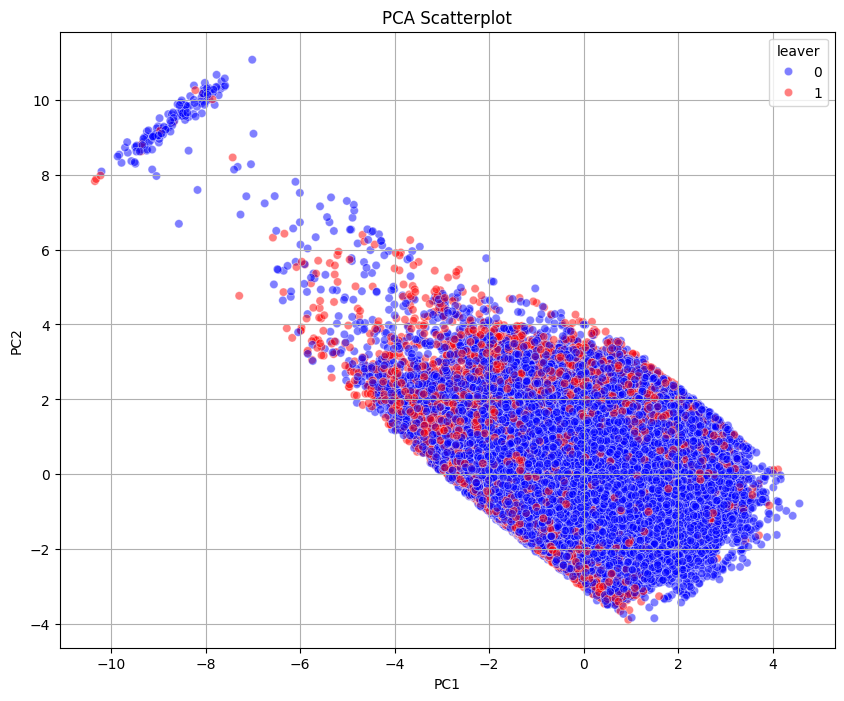

In [130]:
import seaborn as sns

pca_df = pd.DataFrame(features_pca,
                      columns=[f'PC{i+1}' for i in range(pca.n_components_)])
pca_df['leaver'] = y_train.values


plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='leaver', alpha=0.5, palette=['blue', 'red'])
plt.title('PCA Scatterplot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

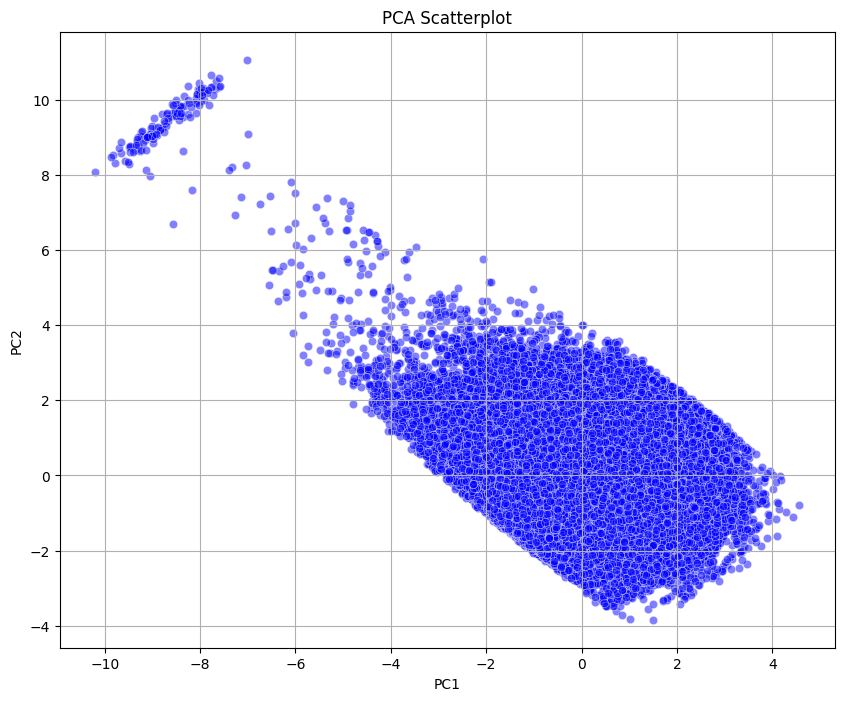

In [134]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df[pca_df.leaver==0], x='PC1', y='PC2', 
                alpha=0.5, color='blue')
plt.title('PCA Scatterplot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

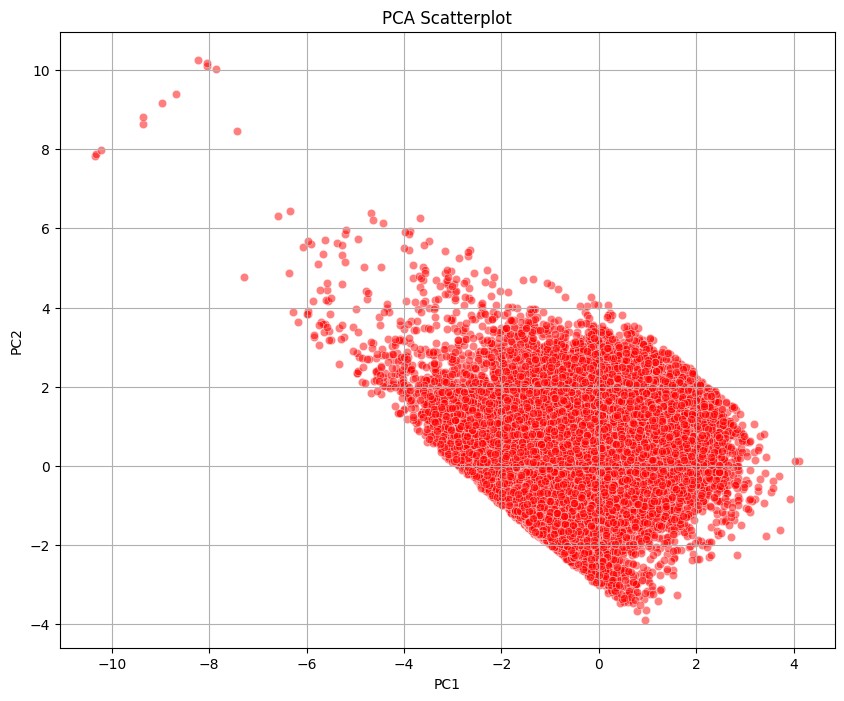

In [135]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df[pca_df.leaver==1], x='PC1', y='PC2', 
                alpha=0.5, color='red')
plt.title('PCA Scatterplot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

In [140]:
y.sum()/len(y)

np.float64(0.09987)